<a href="https://colab.research.google.com/github/SAIVARSHITH-CHIKATI/IIChe_Redesigned/blob/main/GAN_Part_1_Cognitive_Class.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
 !pip install  pandas==1.3.4 numpy==1.21.4 seaborn==0.9.0 matplotlib==3.5.0 scikit-learn==0.20.1

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.5/11.5 MB 20.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.9/15.9 MB 47.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 208.1/208.1 kB 24.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.9/11.9 MB 68.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.7/9.7 MB 6.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.7/43.7 kB 5.4 MB/s eta 0:00:00
INFO: pip is looking at multiple versions of scipy to determine which version is compatible with other requirements. This could take a while.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 38.6/38.6 MB 10.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 38.6/38.6 MB 23.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 38.4/38.4 MB 9.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 36.4/36.4 MB 35.2 MB/s eta 0:00:00
     ━━━━━

In [ ]:
pip install --upgrade tensorflow

In [ ]:
import warnings
warnings.simplefilter('ignore')

import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

import numpy as np
import os
import matplotlib.pyplot as plt
import tensorflow as tf
print(tf.__version__)
from tensorflow.keras import layers
import time
from tensorflow.keras import models
from tqdm import tqdm

2.16.1


Helper Function

In [ ]:
def plot_distribution(real_data,generated_data,discriminator=None,density=True):

    plt.hist(real_data.numpy(), 100, density=density, facecolor='g', alpha=0.75, label='real data')
    plt.hist(generated_data.numpy(), 100, density=density, facecolor='r', alpha=0.75,label='generated data q(z) ')

    if discriminator:
        max_=np.max([int(real_data.numpy().max()),int(generated_data.numpy().max())])
        min_=np.min([int(real_data.numpy().min()),int(generated_data.numpy().min())])
        x=np.linspace(min_, max_, 1000).reshape(-1,1)
        plt.plot(x,tf.math.sigmoid(discriminator(x,training=False).numpy()),label='discriminator',color='k')
        plt.plot(x,0.5*np.ones(x.shape),label='0.5',color='b')
        plt.xlabel('x')

    plt.legend()
    plt.show()

In [ ]:
mean = [10]
cov = [[1]]
X = tf.random.normal((5000,1),mean=10,stddev=1.0)

print("mean:",np.mean(X))
print("standard deviation:",np.std(X))

mean: 10.0199
standard deviation: 0.9937116


In [ ]:
Z = tf.random.normal((5000,1),mean=0,stddev=2)

In [ ]:
Z

<tf.Tensor: shape=(5000, 1), dtype=float32, numpy=
array([[-0.7629799 ],
       [ 0.31701547],
       [ 0.24964154],
       ...,
       [ 0.8073204 ],
       [-0.24915962],
       [ 1.0365074 ]], dtype=float32)>

In [ ]:
print("mean:",np.mean(Z))
print("standard deviation:",np.std(Z))

mean: 0.057306983
standard deviation: 1.9901649


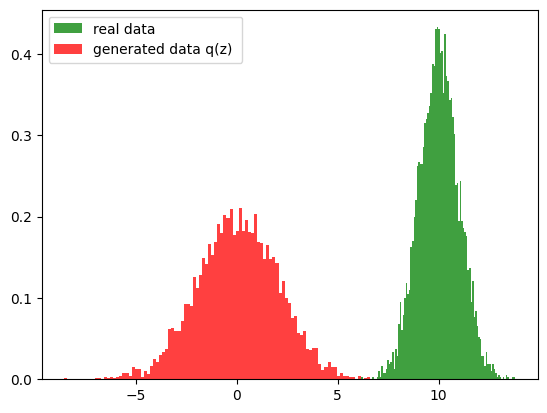

In [ ]:
plot_distribution(X,Z,discriminator=None,density=True)

In [ ]:
Xhat=Z+10

In [ ]:
print("mean:",np.mean(Xhat))
print("standard deviation:",np.std(Xhat))

mean: 10.057307
standard deviation: 1.9901649


# Let's create our first generative model by adding 10 to every sample of  𝑧
 . We will call the result  𝐱̂
  as it's an approximation of  𝐱
 . It is not too difficult to show that  𝐱̂ ∼(𝐱|10,1)

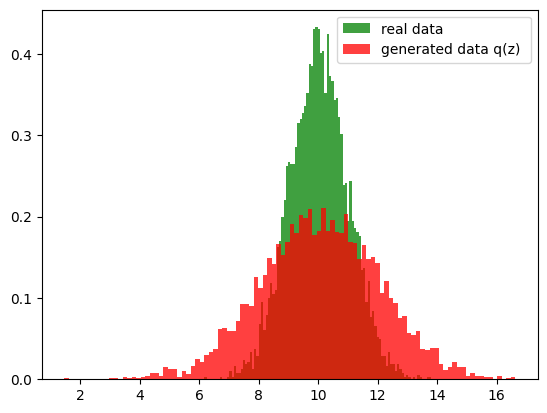

In [ ]:
plot_distribution(X,Xhat,discriminator=None,density=True)

In the case above, since we just add 10 to the latent variable  𝑧
 , we transform  𝑧
  using a deterministic function. We can call this an implicit generative model.

# The **Generator**

There are two networks involved in a GAN, the Generator and the Discriminator. Let's understand the Generator network first.

The Generator is a neural network denoted by  𝐺
 ; the idea is that a neural network can approximate any function (by the Universal Approximation Theorem), so you should be able to generate data samples from any type of distribution.

Our goal is to convert the samples,  𝐳
 , to one that approximates  𝐱̂
 , i.e  𝐱̂ =𝐺(𝐳)
 . Let's build a simple Generator  𝐺(𝐳)=𝐖𝑇𝐳+𝐛
  using Keras.

The following is a function that outputs a generator using Kera's Sequential model object.

In [ ]:
def make_generator_model():
    generator = tf.keras.Sequential()
    generator.add(layers.Dense(1))
    return generator

We can use the Generator to convert  𝐳
  and make a prediction  𝐱̂
 , and display the histogram of the distributions of  𝐱̂
  and  𝐱
 . As the model is not trained, the trained distributions are quite different:

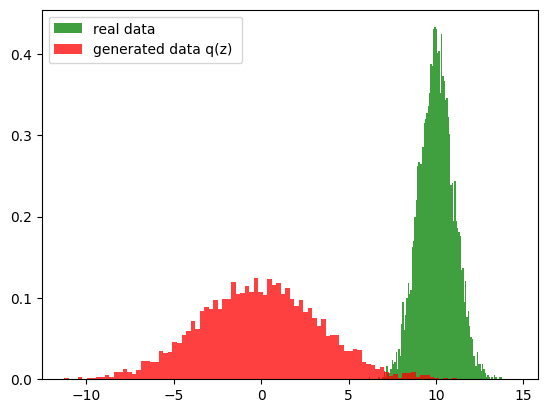

In [ ]:
generator=make_generator_model()

Xhat = generator(Z, training=False)
plot_distribution(real_data=X,generated_data=Xhat)

In [ ]:
print("mean:",np.mean(Xhat))
print("standard deviation:",np.std(Xhat))

mean: -0.09757022
standard deviation: 3.3884323


We will discuss the use of the parameter training=False later on.

# **The Discriminator**

The discriminator  𝐷(𝐱)
  is a neural network that learns to distinguish between actual and generated samples. The simplest Discriminator is a simple logistic regression function. Let's create a discriminator in Keras with one Dense layer; we leave the logistic function out as it will be incorporated in the cost function, which is the convention in Keras.

In [ ]:
def make_discriminator_model():
    discriminator=tf.keras.Sequential()
    discriminator.add(layers.Dense(1))
    return discriminator

discriminator=make_discriminator_model()

The discriminator and generator are randomly initialized, but we can plot the output of each and compare it to the true data distribution, with the generated data in red and the real data in green, and the logistic function as a function of the x axis. We also include the threshold. If the output of the logistic function is less than 0.5, the sample is classified as generated data; conversely, if the output is greater than 0.5, the sample will be classified as data that came from the real distribution.

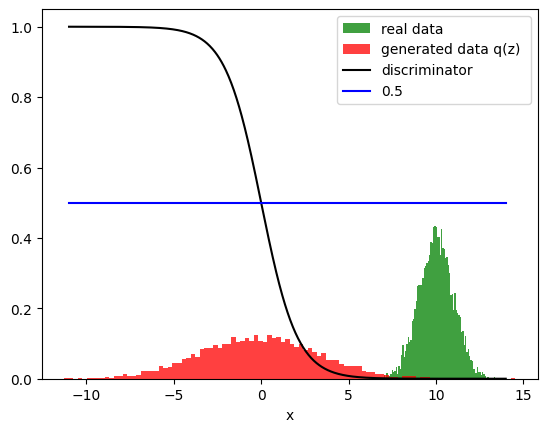

In [ ]:
plot_distribution(real_data=X,generated_data=Xhat,discriminator=discriminator)

Applying the sigmoid function to the discriminator output, we get the probabilites that the samples belong to the real distribution. We can count the number of true samples that the discriminator correctly classifies.

For the real data, the discriminator successfully assigns a probability greater than 0.5 for all 5000 samples:

In [ ]:
py_x=tf.math.sigmoid(discriminator(X,training=False))
np.sum(py_x>0.5)

0

For the generated data, only 1425 out of the 5000 samples are classified as having more than 50% chance of coming from the real distribution.

In [ ]:
py_x=discriminator(Xhat)
np.sum(py_x>0.5)

2263

We can also use the follwoing to find the average value of the sigmoid function for all the samples.

In [ ]:
def get_accuracy(X,Xhat):
    total=0
    py_x=tf.math.sigmoid(discriminator(X,training=False))
    total=np.mean(py_x)
    py_x=tf.math.sigmoid(discriminator(Xhat,training=False))
    total+=np.mean(py_x)
    return total/2

In [ ]:
get_accuracy(X,Xhat)

0.25610703229904175

In many cases, we can instead study the difference in the distribution; in this case, the discriminator is called a Critic, a real-valued function.

# **The Loss Fuction GANs (optional)**

## GANs convert an unsupervised learning problem to a supervised one. Instead of formulating the problem like a two-player minimax game with a value function like in <a href=https://arxiv.org/pdf/1406.2661.pdf?utm_medium=Exinfluencer&utm_source=Exinfluencer&utm_content=000026UJ&utm_term=10006555&utm_id=NA-SkillsNetwork-Channel-SkillsNetworkCoursesIBMDeveloperSkillsNetworkML311Coursera35714171-2022-01-01 >[1], we can treat the problem of maximizing the familiar log-likelihood of the logistic function analogous to minimizing the cross-entropy loss, then incorporate the generator and discriminator.

# Discriminator
## In order to train the GANS, we start off with standard maximization of the likelihood for the discriminator for the standard dataset  D=(x_1,𝑦_1),...,(𝑥𝑁,𝑦𝑁)
 :

# 𝑉(𝐷)=∑_𝑛=1𝑁(𝑦𝑛ln(𝐷(𝐱_𝑛))+(1−𝑦𝑛)ln(1−𝐷(𝐱_𝑛)))

## Where  𝑦=1 for samples from the true distribution and  𝑦=0 for samples from the generator. The goal is to maximize this term with respect to  𝐷:

# 𝑚𝑎𝑥_𝐷(𝑉(𝐷))

## To also incorporate the generated samples, we augment the right side of the equation with the generated  𝑘th sample  𝐱̂ _𝑘
 . As they are not part of the dataset  𝑘∉D
 , we have to include a second summation where  𝑦=0
 . Finally, combining the cases of  𝑦=1
  and  𝑦=0
 , we get:

# 𝑉(𝐷)=∑_n∈Dln(𝐷(𝐱∗𝑛))+∑∗𝑘∉Dln(1−𝐷(𝐱̂ _𝑘))

# Generator
For the generator we simply replace  𝐱̂ _𝑘
  with the  𝐺(𝐳_𝑘)
  .

## 𝑉(𝐺,𝐷)=∑_n∈Dln(𝐷(𝐱∗𝑛))+∑∗𝑘∉Dln(1−𝐷(𝐺(𝐳_𝑘)))

As this is a density estimation problem, it is common to replace the summation with the expected value like in <a href=https://arxiv.org/pdf/1406.2661.pdf?utm_medium=Exinfluencer&utm_source=Exinfluencer&utm_content=000026UJ&utm_term=10006555&utm_id=NA-SkillsNetwork-Channel-SkillsNetworkCoursesIBMDeveloperSkillsNetworkML311Coursera35714171-2022-01-01 >[1]. We replace the summations with an expectation where  𝑝(𝐱)
  is the true distribution and  𝑝(𝐳)
  is the distribution of  𝐳
 .

## 𝑉(𝐷,𝐺)=𝔼∗𝑥∼𝑝(𝐱)ln(𝐷(𝐱))+𝔼∗𝐳∼𝑝(𝐳)ln(1−𝐷(𝐺(𝐳)))

As we are trying to trick the discriminator, we would like to find a  𝐺
  that minimize the above expression, such as:

### 𝑚𝑖𝑛_𝐺𝑚𝑎𝑥_𝐷𝑉(𝐷,𝐺)

# Training GANS
Training Generator
GANs are quite difficult to train, even for a simple example. Let's start off with training the generator in practice.

𝑙𝑜𝑔(1−𝐷(𝐺(𝐳)))
  is difficult to work with as  𝐷(𝐺(𝐳))
  is near one or zero for the first few iterations. This is because the generator is not yet properly trained, and the discriminator can easily distinguish between the generated and actual samples. Therefore we maximize  𝑙𝑜𝑔(𝐷(𝐺(𝐳_𝑘)))
 .

Although the output of the generator passes through the discriminator, we do not update the generator in the optimization step, hence we set the parameter training=False in the actual training steps.

Instead of maximizing the term, we can take the negative and minimize it. The resultant expression can be calculated in Keras using the cross-entropy loss where all the target values are set to one:

## ∑_𝑘∉D𝑙𝑜𝑔(1−𝐷(𝐺(𝐳_𝑘)))

In [ ]:
# This method returns a helper function to compute crossentropy loss
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)
def generator_loss(Xhat):
    return cross_entropy(tf.ones_like(Xhat), Xhat)

# Training Discriminator
We can also use the cross-entropy to train the discriminator; we simply multiply  𝑉(𝐺,𝐷)
  by a negative number, set  𝑦=0
  for the generated values and  𝑦=1
  for the real values. We do not update the generator parameters.

𝑉(𝐺)=∑_n∈D(ln(𝐷(𝐱∗𝑛)))+∑∗𝑘∉Dln(1−𝐷(𝐺(𝐳_𝑘)))

### The first term is the real loss and the second is the fake loss in Keras.

In [ ]:
def discriminator_loss(X, Xhat):
    real_loss = cross_entropy(tf.ones_like(X), X)
    fake_loss = cross_entropy(tf.zeros_like(Xhat), Xhat)
    total_loss = 0.5*(real_loss + fake_loss)
    return total_loss

We create the optimizer for the discriminator and generator:

In [ ]:
generator_optimizer = tf.keras.optimizers.Adam(5e-1,beta_1=0.5,beta_2=0.8)

discriminator_optimizer = tf.keras.optimizers.Adam(5e-1,beta_1=0.5, beta_2=0.8)

We now train the model; as the dataset is small, we will use batch gradient descent.

For each iteration we will generate  𝑀
  real examples  𝐱∗1,...,𝐱∗𝑀
 , these are from the generating distribution  𝑝(𝐱)
 . This would be our actual dataset if we used real data.

We will then generate a sample batch of  𝑀
  noise samples  𝐳∗1,...,𝐳∗𝑀
  from noise prior  𝑝(𝐳)
  and convert the result to a generated image using the generator  𝐱̂ ∗1,...,𝐱̂ ∗𝑀
 .

We determine the output of the discriminator for both the real and generated samples. We calculate the loss and then update the discriminator and generator through their respective stochastic gradients.

The convergence of GAN training is a subject in itself. But let's explore a method that works for this simple dataset. Intuitively, we know that if our generated data is identical to our actual data, the probability of correctly classifying is random. Therefore if the generated and actual data are of equal proportion,  𝐷(𝐱_𝑛)=0.5
  and  𝐷(𝐱̂ _𝑛)=0.5
 .

We only display iterations where the average discriminator output gets closer to 50% for both the generated data and actual data.

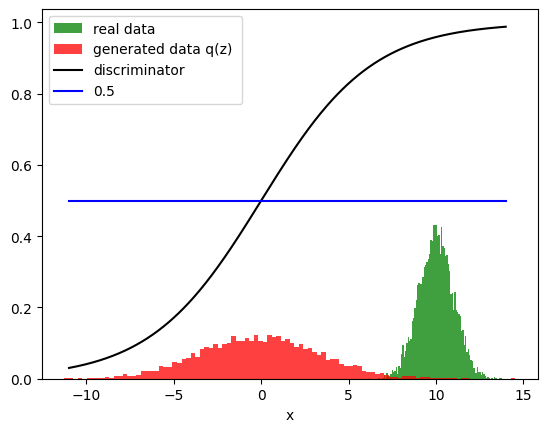

epoch 0


  0%|          | 0/20 [00:00<?, ?it/s]


ValueError: Invalid filepath extension for saving. Please add either a `.keras` extension for the native Keras format (recommended) or a `.h5` extension. Use `model.export(filepath)` if you want to export a SavedModel for use with TFLite/TFServing/etc. Received: filepath=generator.

In [ ]:
#paramters for trainng
epochs=20
BATCH_SIZE=5000
noise_dim=1
epsilon=100


#discrimator and gernerator
tf.random.set_seed(0)
discriminator=make_discriminator_model()
generator=make_generator_model()

tf.config.run_functions_eagerly(True)



gen_loss_epoch=[]
disc_loss_epoch=[]
plot_distribution(real_data=X,generated_data=Xhat,discriminator=discriminator )
print("epoch",0)

for epoch in tqdm(range(epochs)):
    #data for the true distribution of your real data samples training ste
    x = tf.random.normal((BATCH_SIZE,1),mean=10,stddev=1.0)
    #random samples it was found if you increase the  stander deviation, you get better results
    z= tf.random.normal([BATCH_SIZE, noise_dim],mean=0,stddev=10)
    # needed to compute the gradients for a list of variables.
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        #generated sample
        xhat = generator(z, training=True)
        #the output of the discriminator for real data
        real_output = discriminator(x, training=True)
        #the output of the discriminator  data
        fake_output = discriminator(xhat, training=True)
        #loss for each
        gen_loss= generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)
    # Compute the gradients for gen_loss and generator
    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    # Compute the gradients for gen_loss and discriminator
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)
    # Ask the optimizer to apply the processed gradients
    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

  # Save and display the generator and discriminator if the performance increases
    if abs(0.5-get_accuracy(x,xhat))<epsilon:
        epsilon=abs(0.5-get_accuracy(x,xhat))
        generator.save('generator')
        discriminator.save('discriminator')
        print(get_accuracy(x,xhat))
        plot_distribution(real_data=X,generated_data=xhat,discriminator=discriminator )
        print("epoch",epoch)

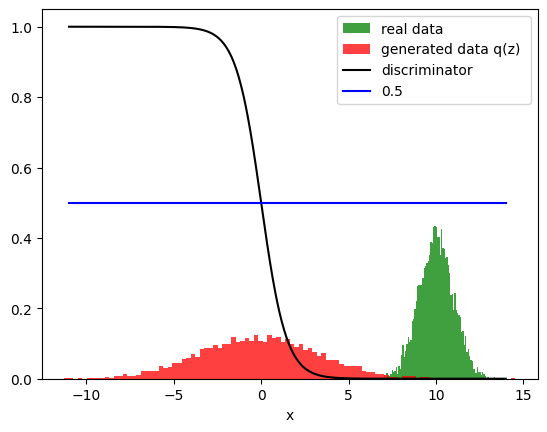

epoch 0


  0%|          | 0/20 [00:00<?, ?it/s]


ValueError: Unknown variable: <KerasVariable shape=(1, 1), dtype=float32, path=sequential_5/dense_5/kernel>. This optimizer can only be called for the variables it was originally built with. When working with a new set of variables, you should recreate a new optimizer instance.

In [ ]:
#paramters for trainng
epochs=20
BATCH_SIZE=5000
noise_dim=1
epsilon=100


#discrimator and gernerator
tf.random.set_seed(0)
discriminator=make_discriminator_model()
generator=make_generator_model()

tf.config.run_functions_eagerly(True)



gen_loss_epoch=[]
disc_loss_epoch=[]
plot_distribution(real_data=X,generated_data=Xhat,discriminator=discriminator )
print("epoch",0)

for epoch in tqdm(range(epochs)):
    #data for the true distribution of your real data samples training ste
    x = tf.random.normal((BATCH_SIZE,1),mean=10,stddev=1.0)
    #random samples it was found if you increase the  stander deviation, you get better results
    z= tf.random.normal([BATCH_SIZE, noise_dim],mean=0,stddev=10)
    # needed to compute the gradients for a list of variables.
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        #generated sample
        xhat = generator(z, training=True)
        #the output of the discriminator for real data
        real_output = discriminator(x, training=True)
        #the output of the discriminator  data
        fake_output = discriminator(xhat, training=True)
        #loss for each
        gen_loss= generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)
    # Compute the gradients for gen_loss and generator
    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    # Compute the gradients for gen_loss and discriminator
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)
    # Ask the optimizer to apply the processed gradients
    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

  # Save and display the generator and discriminator if the performance increases
    if abs(0.5-get_accuracy(x,xhat))<epsilon:
        epsilon=abs(0.5-get_accuracy(x,xhat))
        # Add '.keras' extension to the filenames
        generator.save('generator.keras') # Save generator with .keras extension
        discriminator.save('discriminator.keras') # Save discriminator with .keras extension
        print(get_accuracy(x,xhat))
        plot_distribution(real_data=X,generated_data=xhat,discriminator=discriminator )
        print("epoch",epoch)

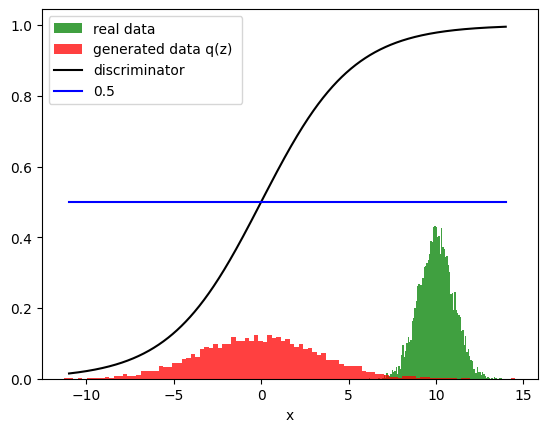

epoch 0


  0%|          | 0/20 [00:00<?, ?it/s]

0.2873983383178711


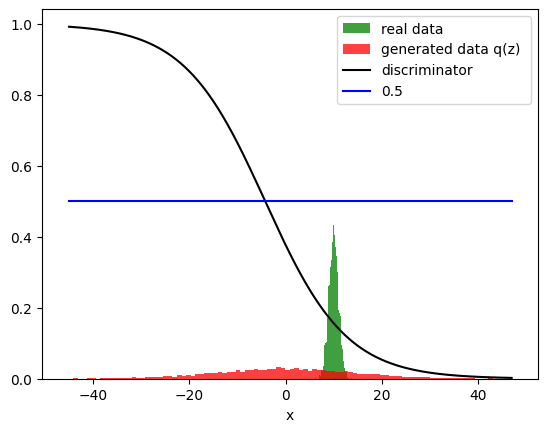

  5%|▌         | 1/20 [00:00<00:13,  1.40it/s]

epoch 0
0.6362104415893555


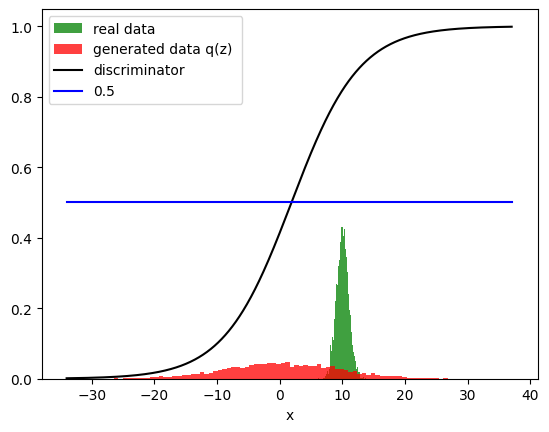

 20%|██        | 4/20 [00:01<00:04,  3.32it/s]

epoch 1
0.6126230359077454


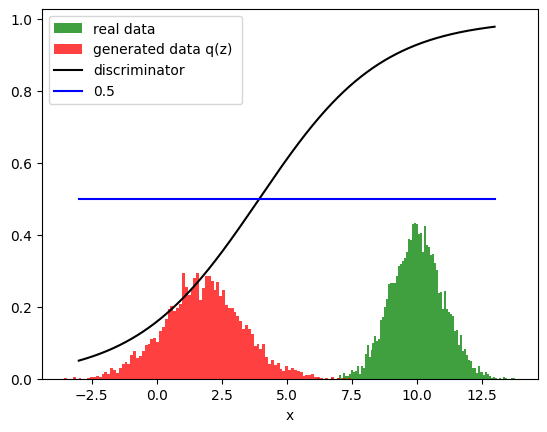

 30%|███       | 6/20 [00:02<00:04,  3.02it/s]

epoch 5
0.551984429359436


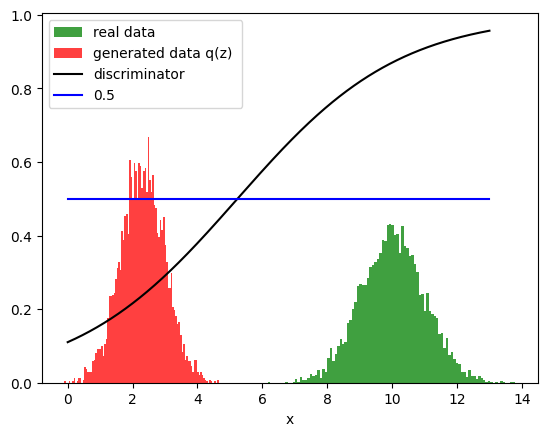

 35%|███▌      | 7/20 [00:02<00:05,  2.37it/s]

epoch 6
0.5435090065002441


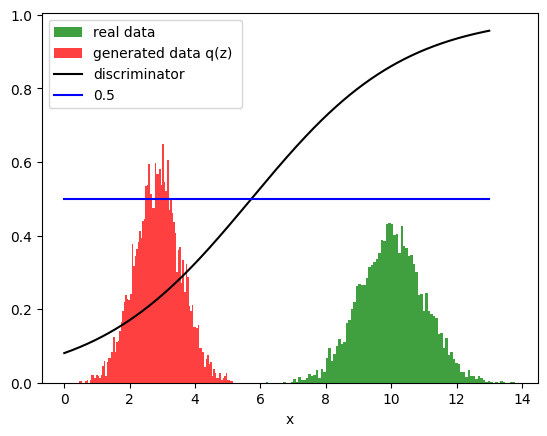

 50%|█████     | 10/20 [00:03<00:03,  3.21it/s]

epoch 7
0.4972831606864929


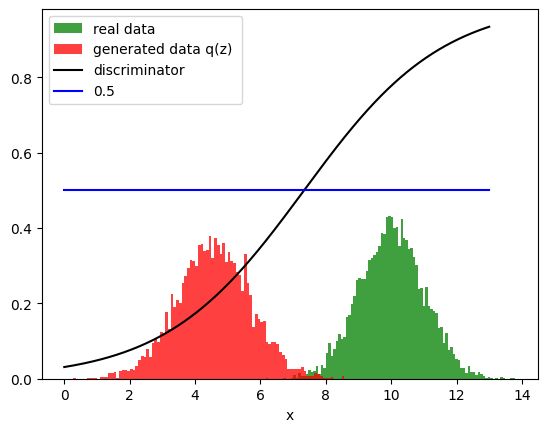

 65%|██████▌   | 13/20 [00:05<00:02,  3.05it/s]

epoch 10


100%|██████████| 20/20 [00:05<00:00,  3.64it/s]


In [ ]:
#paramters for trainng
epochs=20
BATCH_SIZE=5000
noise_dim=1
epsilon=100


#discrimator and gernerator
tf.random.set_seed(0)
discriminator=make_discriminator_model()
generator=make_generator_model()

# Create optimizers AFTER the models are defined
generator_optimizer = tf.keras.optimizers.Adam(5e-1,beta_1=0.5,beta_2=0.8)
discriminator_optimizer = tf.keras.optimizers.Adam(5e-1,beta_1=0.5, beta_2=0.8)

tf.config.run_functions_eagerly(True)



gen_loss_epoch=[]
disc_loss_epoch=[]
plot_distribution(real_data=X,generated_data=Xhat,discriminator=discriminator )
print("epoch",0)

for epoch in tqdm(range(epochs)):
    #data for the true distribution of your real data samples training ste
    x = tf.random.normal((BATCH_SIZE,1),mean=10,stddev=1.0)
    #random samples it was found if you increase the  stander deviation, you get better results
    z= tf.random.normal([BATCH_SIZE, noise_dim],mean=0,stddev=10)
    # needed to compute the gradients for a list of variables.
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        #generated sample
        xhat = generator(z, training=True)
        #the output of the discriminator for real data
        real_output = discriminator(x, training=True)
        #the output of the discriminator  data
        fake_output = discriminator(xhat, training=True)
        #loss for each
        gen_loss= generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)
    # Compute the gradients for gen_loss and generator
    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    # Compute the gradients for gen_loss and discriminator
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)
    # Ask the optimizer to apply the processed gradients
    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

  # Save and display the generator and discriminator if the performance increases
    if abs(0.5-get_accuracy(x,xhat))<epsilon:
        epsilon=abs(0.5-get_accuracy(x,xhat))
        # Add '.keras' extension to the filenames
        generator.save('generator.keras') # Save generator with .keras extension
        discriminator.save('discriminator.keras') # Save discriminator with .keras extension
        print(get_accuracy(x,xhat))
        plot_distribution(real_data=X,generated_data=xhat,discriminator=discriminator )
        print("epoch",epoch)

In [ ]:
generator=make_generator_model()
generator= models.load_model('generator')
xhat=generator(z)
discriminator=models.load_model('discriminator')
plot_distribution(real_data=X,generated_data=xhat,discriminator=discriminator )

ValueError: File format not supported: filepath=generator. Keras 3 only supports V3 `.keras` files and legacy H5 format files (`.h5` extension). Note that the legacy SavedModel format is not supported by `load_model()` in Keras 3. In order to reload a TensorFlow SavedModel as an inference-only layer in Keras 3, use `keras.layers.TFSMLayer(generator, call_endpoint='serving_default')` (note that your `call_endpoint` might have a different name).